In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Directorio donde está el notebook
NOTEBOOK_DIR = Path().resolve()

# Carpeta del proyecto p05_creditos_riesgo (un nivel arriba)
BASE_DIR = NOTEBOOK_DIR.parent

DATA_DIR = BASE_DIR / "data"
IMG_DIR  = BASE_DIR / "img"

DATA_DIR, IMG_DIR


(PosixPath('/Users/hugobaghetti/Desktop/PROYECTOS/Proyecto Mineria/p05_creditos_riesgo/data'),
 PosixPath('/Users/hugobaghetti/Desktop/PROYECTOS/Proyecto Mineria/p05_creditos_riesgo/img'))

In [2]:
ruta_csv = DATA_DIR / "creditos_raw.csv"
print(ruta_csv)

df = pd.read_csv(ruta_csv)

df.head()
df.columns, df.shape


/Users/hugobaghetti/Desktop/PROYECTOS/Proyecto Mineria/p05_creditos_riesgo/data/creditos_raw.csv


(Index(['credito_id', 'cliente_id', 'segmento', 'monto_credito', 'plazo_meses',
        'tasa_interes_anual', 'region', 'ingreso_mensual',
        'antiguedad_cliente_anios', 'estado'],
       dtype='object'),
 (80, 10))

In [3]:
# Copiamos el DF original para no tocar df directamente
df_scored = df.copy()

# --- 3.1 Score por mora / atraso ---
def score_mora(row):
    # Intentamos usar atraso_maximo_dias si existe
    atraso = None
    if "atraso_maximo_dias" in row.index:
        atraso = row["atraso_maximo_dias"]
    else:
        # Si no existe, estimamos por banderas de mora_30d / 60d / 90d si están
        atraso = 0
        if "mora_30d" in row.index and row["mora_30d"] > 0:
            atraso = max(atraso, 30)
        if "mora_60d" in row.index and row["mora_60d"] > 0:
            atraso = max(atraso, 60)
        if "mora_90d" in row.index and row["mora_90d"] > 0:
            atraso = max(atraso, 90)

    if atraso is None:
        return 0

    if atraso >= 90:
        return 5
    elif atraso >= 60:
        return 4
    elif atraso >= 30:
        return 3
    elif atraso > 0:
        return 2
    else:
        return 0

df_scored["score_mora"] = df_scored.apply(score_mora, axis=1)

# --- 3.2 Score por ratio monto / ingreso ---
if "monto" in df_scored.columns and "ingreso_mensual" in df_scored.columns:
    df_scored["ratio_monto_ingreso"] = (
        df_scored["monto"] / df_scored["ingreso_mensual"].replace(0, pd.NA)
    )

    def score_ratio(r):
        if pd.isna(r):
            return 0
        if r >= 0.6:
            return 3
        elif r >= 0.4:
            return 2
        elif r >= 0.2:
            return 1
        else:
            return 0

    df_scored["score_ratio"] = df_scored["ratio_monto_ingreso"].apply(score_ratio)
else:
    df_scored["ratio_monto_ingreso"] = pd.NA
    df_scored["score_ratio"] = 0

# --- 3.3 Score por monto del crédito ---
if "monto" in df_scored.columns:
    def score_monto(m):
        # ajustable según montos típicos que uses
        if m >= 1_500_000:
            return 2
        elif m >= 800_000:
            return 1
        else:
            return 0

    df_scored["score_monto"] = df_scored["monto"].apply(score_monto)
else:
    df_scored["score_monto"] = 0

# --- 3.4 Score por score de buró (si existe) ---
if "score_buro" in df_scored.columns:
    # Suponiendo score_buro entre 300 y 900 aprox.
    def score_buro_norm(s):
        if pd.isna(s):
            return 0
        if s < 500:
            return 3   # peor buró → más riesgo
        elif s < 650:
            return 2
        elif s < 750:
            return 1
        else:
            return 0

    df_scored["score_buro_norm"] = df_scored["score_buro"].apply(score_buro_norm)
else:
    df_scored["score_buro_norm"] = 0

# --- 3.5 Score total y segmento de riesgo ---
componentes = ["score_mora", "score_ratio", "score_monto", "score_buro_norm"]
df_scored["score_total"] = df_scored[componentes].sum(axis=1)

def clasificar_riesgo(score):
    if score >= 10:
        return "Alto"
    elif score >= 7:
        return "Medio"
    else:
        return "Bajo"

df_scored["segmento_riesgo"] = df_scored["score_total"].apply(clasificar_riesgo)

# Miramos un resumen
df_scored[["score_mora", "score_ratio", "score_monto", "score_buro_norm",
           "score_total", "segmento_riesgo"]].head()


,score_mora,score_ratio,score_monto,score_buro_norm,score_total,segmento_riesgo
0,0,0,0,0,0,Bajo
1,0,0,0,0,0,Bajo
2,0,0,0,0,0,Bajo
3,0,0,0,0,0,Bajo
4,0,0,0,0,0,Bajo


In [4]:
# Conteo de créditos por segmento de riesgo
df_scored["segmento_riesgo"].value_counts()


segmento_riesgo
Bajo    80
Name: count, dtype: int64

In [5]:
if "monto" in df_scored.columns:
    df_scored.groupby("segmento_riesgo")["monto"].agg(["count", "mean", "sum"])


In [6]:
# 1) Guardar el CSV segmentado
salida_csv = DATA_DIR / "creditos_riesgo_segmentado.csv"
df_scored.to_csv(salida_csv, index=False)
salida_csv


PosixPath('/Users/hugobaghetti/Desktop/PROYECTOS/Proyecto Mineria/p05_creditos_riesgo/data/creditos_riesgo_segmentado.csv')

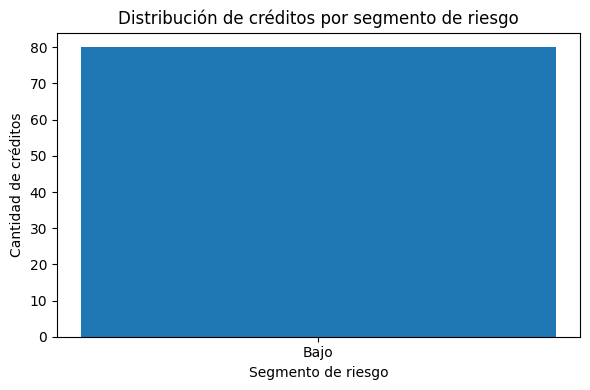

PosixPath('/Users/hugobaghetti/Desktop/PROYECTOS/Proyecto Mineria/p05_creditos_riesgo/img/creditos_por_segmento_riesgo.png')

In [7]:
# 2) Gráfico simple: cantidad de créditos por segmento de riesgo
segmentos = df_scored["segmento_riesgo"].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(segmentos.index, segmentos.values)
plt.xlabel("Segmento de riesgo")
plt.ylabel("Cantidad de créditos")
plt.title("Distribución de créditos por segmento de riesgo")
plt.tight_layout()

ruta_img = IMG_DIR / "creditos_por_segmento_riesgo.png"
plt.savefig(ruta_img, dpi=150)
plt.show()

ruta_img
